# Lutter contre la masculinité algorithmique et les biais toxiques 
Mal paramétrés, les algorithmes de recommandations peuvent mener les utilisateurs à tourner en rond. Il faut savoir que 80% du contenu Netflix visionné correspond aux recommandations du site et seul 10% du catalogue Spotify est réellement utlisé.Ceci mène alors à moins d'exploration pour les consommateurs, et plus de standardisation pour les auteurs.

L'objectif de ce projet est de **contourner ce biais pour proposer aux utilisateurs du contenu qu'ils n'auraient pas cherché par eux-mêmes.**

# Importation des librairies

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Pre-processing
import ast
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Algorithme de recommandation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Visualisation posters
from PIL import Image
import urllib.request

# WordCloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

# Chargement & vérification des données

In [2]:
TMDb_brut = pd.read_csv("TMDb_Brut_4.csv")

Je procède d'abord à une première analyse descriptive des données :

In [3]:
TMDb_brut.head()

TMDb_id  IMDB_id           Titre  \
0        5   113101      Four Rooms   
1        6   107286  Judgment Night   
2       11    76759       Star Wars   
3       12   266543    Finding Nemo   
4       13   109830    Forrest Gump   

                                               Genre        Date Pays  \
0  [{'id': 80, 'name': 'Crime'}, {'id': 35, 'name...  1995-12-09   US   
1  [{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...  1993-10-15   JP   
2  [{'id': 12, 'name': 'Adventure'}, {'id': 28, '...  1977-05-25   US   
3  [{'id': 16, 'name': 'Animation'}, {'id': 10751...  2003-05-30   US   
4  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...  1994-06-23   US   

   Runtime                                               Cast  \
0       98  [{'adult': False, 'gender': 2, 'id': 3129, 'kn...   
1      109  [{'adult': False, 'gender': 2, 'id': 2880, 'kn...   
2      121  [{'adult': False, 'gender': 2, 'id': 2, 'known...   
3      100  [{'adult': False, 'gender': 2, 'id': 13, 'know...   
4      142  [{'adult': False, 'gender': 2, 'id': 31, 'know...   

                                                Crew    Budget    Revenue  \
0  [{'adult': False, 'gender': 1, 'id': 3110, 'kn...   4000000    4257354   
1  [{'adult': False, 'gender': 2, 'id': 2042, 'kn...  21000000   12136938   
2  [{'adult': False, 'gender': 2, 'id': 1, 'known...  11000000  775398007   
3  [{'adult': False, 'gender': 2, 'id': 7, 'known...  94000000  940335536   
4  [{'adult': False, 'gender': 2, 'id': 37, 'know...  55000000  677387716   

    Note  Nb_notes               Collection  \
0  5.682      2207                      NaN   
1  6.561       253                      NaN   
2  8.205     17647     Star Wars Collection   
3  7.825     16767  Finding Nemo Collection   
4  8.480     23243                      NaN   

                                    Films_Collection  \
0                                                NaN   
1                                                NaN   
2  [{'adult': False, 'backdrop_path': '/yrdAamkeq...   
3  [{'adult': False, 'backdrop_path': '/bvpI11RJb...   
4                                                NaN   

                                            Keywords  \
0  [{'id': 612, 'name': 'hotel'}, {'id': 613, 'na...   
1  [{'id': 520, 'name': 'chicago, illinois'}, {'i...   
2  [{'id': 803, 'name': 'android'}, {'id': 4270, ...   
3  [{'id': 970, 'name': 'parent child relationshi...   
4  [{'id': 422, 'name': 'vietnam veteran'}, {'id'...   

                                              Poster  Bechdel  
0  https://image.tmdb.org/t/p/w185/75aHn1NOYXh4M7...      3.0  
1  https://image.tmdb.org/t/p/w185/rYFAvSPlQUCeba...      NaN  
2  https://image.tmdb.org/t/p/w185/6FfCtAuVAW8XJj...      1.0  
3  https://image.tmdb.org/t/p/w185/eHuGQ10FUzK1md...      1.0  
4  https://image.tmdb.org/t/p/w185/saHP97rTPS5eLm...      1.0

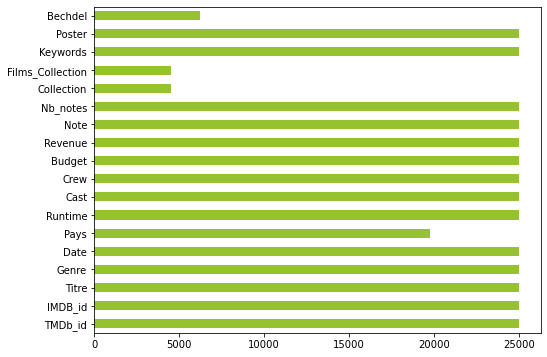

In [4]:
# Je regarde la répartition de mes données
infos_data = TMDb_brut.count().plot(kind = 'barh', figsize=(8, 6), color = '#95C22D')

In [5]:
# Je vérifie l'existence et la quantité des valeurs manquantes dans chaque colonne 
missing = TMDb_brut.isna().sum()*100/len(TMDb_brut)
missing.sort_values(ascending = False)

Films_Collection    81.901718
Collection          81.901718
Bechdel             75.117859
Pays                20.974830
Revenue              0.000000
Poster               0.000000
Keywords             0.000000
Nb_notes             0.000000
Note                 0.000000
TMDb_id              0.000000
IMDB_id              0.000000
Crew                 0.000000
Cast                 0.000000
Runtime              0.000000
Date                 0.000000
Genre                0.000000
Titre                0.000000
Budget               0.000000
dtype: float64

### Création d'un nouveau dataframe

Afin d'éviter tout data leakage, je vais créer un nouveau dataframe sur lequel je vais effectuer toutes les modifications. Ainsi, je conserve les data dans leur état initial : 

In [6]:
# Nouveau DataFrame
data_transformed = TMDb_brut.copy()

# Je supprime les éventuels doublons
data_transformed.drop_duplicates(inplace = True)

# Notations des films

L'objectif de mon algorithme de recommandation est de proposer du contenu qui plaira à mon utilisateur. Je choisis donc d'utiliser la formule utilisée par TMDb pour calculer une note pondérée et ainsi choisir les films les mieux notés en fonction du nombre de votes reçus : 

In [7]:
# Je définis mes différents paramètres
V = data_transformed['Nb_notes']
R = data_transformed['Note']
C = data_transformed['Note'].mean()

# Je récupère le nombre de notes correspondant au 7e quantile
m = data_transformed['Nb_notes'].quantile(0.70) 

# Je calcule ma note pondérée
data_transformed['Note_pondérée'] = (V/(V+m) * R) + (m/(m+V) * C)

Je souhaite conserver uniquement les films qui ont une note supérieure ou égale à 70% de mon dataset :

In [9]:
# Je définis les 30% de mon dataset
note_min = data_transformed['Note_pondérée'].quantile(0.3)
note_min

# Je ne conserve que les films dont la note est égale ou supérieure à 70% du dataset
data_transformed = data_transformed.loc[data_transformed['Note_pondérée'] >= note_min]
data_transformed.reset_index(drop = True, inplace = True)

# Et je vérifie qu'il n'y ait pas d'os dans le paté
data_transformed.head()

TMDb_id  IMDB_id            Titre  \
0        6   107286   Judgment Night   
1       11    76759        Star Wars   
2       12   266543     Finding Nemo   
3       13   109830     Forrest Gump   
4       14   169547  American Beauty   

                                               Genre        Date Pays  \
0  [{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...  1993-10-15   JP   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 28, '...  1977-05-25   US   
2  [{'id': 16, 'name': 'Animation'}, {'id': 10751...  2003-05-30   US   
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...  1994-06-23   US   
4                      [{'id': 18, 'name': 'Drama'}]  1999-09-15   US   

   Runtime                                               Cast  \
0      109  [{'adult': False, 'gender': 2, 'id': 2880, 'kn...   
1      121  [{'adult': False, 'gender': 2, 'id': 2, 'known...   
2      100  [{'adult': False, 'gender': 2, 'id': 13, 'know...   
3      142  [{'adult': False, 'gender': 2, 'id': 31, 'know...   
4      122  [{'adult': False, 'gender': 2, 'id': 1979, 'kn...   

                                                Crew    Budget    Revenue  \
0  [{'adult': False, 'gender': 2, 'id': 2042, 'kn...  21000000   12136938   
1  [{'adult': False, 'gender': 2, 'id': 1, 'known...  11000000  775398007   
2  [{'adult': False, 'gender': 2, 'id': 7, 'known...  94000000  940335536   
3  [{'adult': False, 'gender': 2, 'id': 37, 'know...  55000000  677387716   
4  [{'adult': False, 'gender': 2, 'id': 153, 'kno...  15000000  356296601   

    Note  Nb_notes               Collection  \
0  6.561       253                      NaN   
1  8.205     17647     Star Wars Collection   
2  7.825     16767  Finding Nemo Collection   
3  8.480     23243                      NaN   
4  8.034     10468                      NaN   

                                    Films_Collection  \
0                                                NaN   
1  [{'adult': False, 'backdrop_path': '/yrdAamkeq...   
2  [{'adult': False, 'backdrop_path': '/bvpI11RJb...   
3                                                NaN   
4                                                NaN   

                                            Keywords  \
0  [{'id': 520, 'name': 'chicago, illinois'}, {'i...   
1  [{'id': 803, 'name': 'android'}, {'id': 4270, ...   
2  [{'id': 970, 'name': 'parent child relationshi...   
3  [{'id': 422, 'name': 'vietnam veteran'}, {'id'...   
4  [{'id': 596, 'name': 'adultery'}, {'id': 970, ...   

                                              Poster  Bechdel  Note_pondérée  
0  https://image.tmdb.org/t/p/w185/rYFAvSPlQUCeba...      NaN       6.439781  
1  https://image.tmdb.org/t/p/w185/6FfCtAuVAW8XJj...      1.0       8.171083  
2  https://image.tmdb.org/t/p/w185/eHuGQ10FUzK1md...      1.0       7.796628  
3  https://image.tmdb.org/t/p/w185/saHP97rTPS5eLm...      1.0       8.450308  
4  https://image.tmdb.org/t/p/w185/wby9315QzVKdW9...      3.0       7.982724

# Extraction des informations
Mon tableau contient énormément d'informations qui sont noyées et rangées dans des boîtes. Je vais extraire les informations qui m'intéressent petit à petit. Tout d'abord, je choisis de ne conserver que l'année de distribution du film :

In [10]:
# Création d'une nouvelle colonne contenant seulement l'année de distribution
data_transformed['Année'] = data_transformed['Date'].map(lambda x: x.split('-')[0])

# Je choisis de regrouper les années en décennie
decades = []
for i in data_transformed['Année'] :
    stringyear = str(i)
    decade = stringyear[0:3] + '0'
    decades.append(int(decade))
data_transformed['Decade'] = decades

# Je vérifie qu'il n'y ait pas d'os dans le pâté
data_transformed.head()

TMDb_id  IMDB_id            Titre  \
0        6   107286   Judgment Night   
1       11    76759        Star Wars   
2       12   266543     Finding Nemo   
3       13   109830     Forrest Gump   
4       14   169547  American Beauty   

                                               Genre        Date Pays  \
0  [{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...  1993-10-15   JP   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 28, '...  1977-05-25   US   
2  [{'id': 16, 'name': 'Animation'}, {'id': 10751...  2003-05-30   US   
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...  1994-06-23   US   
4                      [{'id': 18, 'name': 'Drama'}]  1999-09-15   US   

   Runtime                                               Cast  \
0      109  [{'adult': False, 'gender': 2, 'id': 2880, 'kn...   
1      121  [{'adult': False, 'gender': 2, 'id': 2, 'known...   
2      100  [{'adult': False, 'gender': 2, 'id': 13, 'know...   
3      142  [{'adult': False, 'gender': 2, 'id': 31, 'know...   
4      122  [{'adult': False, 'gender': 2, 'id': 1979, 'kn...   

                                                Crew    Budget  ...   Note  \
0  [{'adult': False, 'gender': 2, 'id': 2042, 'kn...  21000000  ...  6.561   
1  [{'adult': False, 'gender': 2, 'id': 1, 'known...  11000000  ...  8.205   
2  [{'adult': False, 'gender': 2, 'id': 7, 'known...  94000000  ...  7.825   
3  [{'adult': False, 'gender': 2, 'id': 37, 'know...  55000000  ...  8.480   
4  [{'adult': False, 'gender': 2, 'id': 153, 'kno...  15000000  ...  8.034   

   Nb_notes               Collection  \
0       253                      NaN   
1     17647     Star Wars Collection   
2     16767  Finding Nemo Collection   
3     23243                      NaN   
4     10468                      NaN   

                                    Films_Collection  \
0                                                NaN   
1  [{'adult': False, 'backdrop_path': '/yrdAamkeq...   
2  [{'adult': False, 'backdrop_path': '/bvpI11RJb...   
3                                                NaN   
4                                                NaN   

                                            Keywords  \
0  [{'id': 520, 'name': 'chicago, illinois'}, {'i...   
1  [{'id': 803, 'name': 'android'}, {'id': 4270, ...   
2  [{'id': 970, 'name': 'parent child relationshi...   
3  [{'id': 422, 'name': 'vietnam veteran'}, {'id'...   
4  [{'id': 596, 'name': 'adultery'}, {'id': 970, ...   

                                              Poster Bechdel  Note_pondérée  \
0  https://image.tmdb.org/t/p/w185/rYFAvSPlQUCeba...     NaN       6.439781   
1  https://image.tmdb.org/t/p/w185/6FfCtAuVAW8XJj...     1.0       8.171083   
2  https://image.tmdb.org/t/p/w185/eHuGQ10FUzK1md...     1.0       7.796628   
3  https://image.tmdb.org/t/p/w185/saHP97rTPS5eLm...     1.0       8.450308   
4  https://image.tmdb.org/t/p/w185/wby9315QzVKdW9...     3.0       7.982724   

   Année Decade  
0   1993   1990  
1   1977   1970  
2   2003   2000  
3   1994   1990  
4   1999   1990  

[5 rows x 21 columns]

Ensuite je décide de regrouper les différents pays d'origine des films en régions pour pouvoir les recommander ensuite plus facilement :

In [11]:
# Je crée une liste de régions des différents pays
Europe = ['FR', 'GB', 'IT', 'DE', 'ES', 
          'DK', 'SE', 'CH', 'BE', 'AT', 
          'HR', 'RO', 'RU', 'PL', 'FI', 
          'LU', 'RS', 'IE', 'NO', 'PT', 
          'SU', 'GR', 'HU', 'EE', 'UA', 
          'BG', 'IS', 'MK', 'CY', 'CZ', 
          'LT', 'BY']
Asie = ['JP', 'HK', 'IN', 'KR', 
        'CN', 'SG', 'TH', 'XC', 
        'ID', 'TW', 'KZ', 'PH', 
        'KP', 'BD']
Afrique = ['AE', 'ZA', 'EG', 'TN']
Orient = ['TR', 'IR', 'IL', 'PS', 'AZ', 'AM']
Oceanie = ['AU', 'NZ', 'NL']
Amérique_latine = ['BR', 'MX', 'AR', 'CL', 'BS', 
           'CO', 'PE', 'PR', 'CU']
Nord_Américain = ['US', 'CA']

# Je définie une fonction qui va classer chaque pays dans la bonne région
def regions(pays):
    if pays in Europe :
        return 'Europe'
    elif pays in Nord_Américain :
        return 'Nord Américain'
    elif pays in Amérique_latine :
        return 'Amérique latine'
    elif pays in Afrique :
        return 'Afrique'
    elif pays in Asie :
        return 'Asie'
    elif pays in Orient :
        return 'Orient'
    elif pays in Oceanie :
        return 'Oceanie'
    else : 
        return np.nan

# J'applique cette fonction à toute ma colonne Pays
data_transformed['Regions'] = data_transformed['Pays'].map(lambda x: regions(x))

# Je vérifie qu'il n'y ait pas d'os dans le pâté
data_transformed.head()

TMDb_id  IMDB_id            Titre  \
0        6   107286   Judgment Night   
1       11    76759        Star Wars   
2       12   266543     Finding Nemo   
3       13   109830     Forrest Gump   
4       14   169547  American Beauty   

                                               Genre        Date Pays  \
0  [{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...  1993-10-15   JP   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 28, '...  1977-05-25   US   
2  [{'id': 16, 'name': 'Animation'}, {'id': 10751...  2003-05-30   US   
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...  1994-06-23   US   
4                      [{'id': 18, 'name': 'Drama'}]  1999-09-15   US   

   Runtime                                               Cast  \
0      109  [{'adult': False, 'gender': 2, 'id': 2880, 'kn...   
1      121  [{'adult': False, 'gender': 2, 'id': 2, 'known...   
2      100  [{'adult': False, 'gender': 2, 'id': 13, 'know...   
3      142  [{'adult': False, 'gender': 2, 'id': 31, 'know...   
4      122  [{'adult': False, 'gender': 2, 'id': 1979, 'kn...   

                                                Crew    Budget  ...  Nb_notes  \
0  [{'adult': False, 'gender': 2, 'id': 2042, 'kn...  21000000  ...       253   
1  [{'adult': False, 'gender': 2, 'id': 1, 'known...  11000000  ...     17647   
2  [{'adult': False, 'gender': 2, 'id': 7, 'known...  94000000  ...     16767   
3  [{'adult': False, 'gender': 2, 'id': 37, 'know...  55000000  ...     23243   
4  [{'adult': False, 'gender': 2, 'id': 153, 'kno...  15000000  ...     10468   

                Collection                                   Films_Collection  \
0                      NaN                                                NaN   
1     Star Wars Collection  [{'adult': False, 'backdrop_path': '/yrdAamkeq...   
2  Finding Nemo Collection  [{'adult': False, 'backdrop_path': '/bvpI11RJb...   
3                      NaN                                                NaN   
4                      NaN                                                NaN   

                                            Keywords  \
0  [{'id': 520, 'name': 'chicago, illinois'}, {'i...   
1  [{'id': 803, 'name': 'android'}, {'id': 4270, ...   
2  [{'id': 970, 'name': 'parent child relationshi...   
3  [{'id': 422, 'name': 'vietnam veteran'}, {'id'...   
4  [{'id': 596, 'name': 'adultery'}, {'id': 970, ...   

                                              Poster Bechdel Note_pondérée  \
0  https://image.tmdb.org/t/p/w185/rYFAvSPlQUCeba...     NaN      6.439781   
1  https://image.tmdb.org/t/p/w185/6FfCtAuVAW8XJj...     1.0      8.171083   
2  https://image.tmdb.org/t/p/w185/eHuGQ10FUzK1md...     1.0      7.796628   
3  https://image.tmdb.org/t/p/w185/saHP97rTPS5eLm...     1.0      8.450308   
4  https://image.tmdb.org/t/p/w185/wby9315QzVKdW9...     3.0      7.982724   

   Année  Decade         Regions  
0   1993    1990            Asie  
1   1977    1970  Nord Américain  
2   2003    2000  Nord Américain  
3   1994    1990  Nord Américain  
4   1999    1990  Nord Américain  

[5 rows x 22 columns]

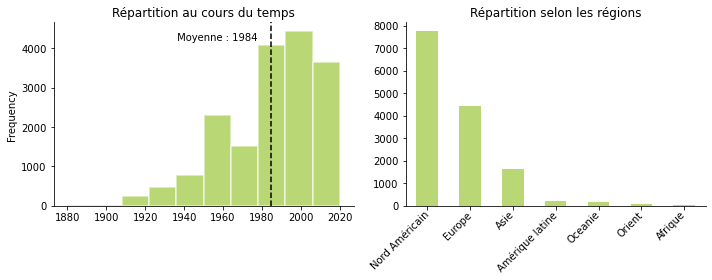

In [12]:
# Répartition des films selon les années ou les pays de production
fig, ax = plt.subplots(1,2, figsize=(10,4))

data_transformed['Decade'].plot.hist(ax = ax[0], 
                                     color = '#95C22D',
                                     edgecolor = 'w', 
                                     linewidth = 1.5, 
                                     alpha = 0.65).set(title = 'Répartition au cours du temps')

_ = ax[0].axvline(data_transformed['Decade'].mean(), 
                  color = 'k',
                  linestyle = 'dashed')

_ = ax[0].text(1935, 4220, f" Moyenne : {np.int(data_transformed['Decade'].mean())}", fontsize = 10)

data_transformed['Regions'].value_counts().plot.bar(ax = ax[1], 
                                                    color = '#95C22D',
                                                    alpha = 0.65,
                                                    y = 'Régions').set(title = 'Répartition selon les régions')

plt.setp(ax[1].get_xticklabels(), rotation = 45, ha = "right", va = "center", rotation_mode = "anchor")

for spine in ['top', 'right']:
            ax[0].spines[spine].set_visible(False)
            ax[1].spines[spine].set_visible(False)

plt.tight_layout()
plt.savefig('Fig_1.png')

### Catégories des films (Comédie, drame, horreur, ...)
Je définis une fonction afin d'extraire de la colonne 'Genre' les différentes catégories de chaque film. Je décide de parler en termes de catégorie afin d'éviter qu'on s'emmêle les pinceaux avec les genres des acteurs ensuite.
Étant donné que je veux créer un algorithme de recommandation, j'estime avoir besoin au maximum de 3 catégories par films. Certains films en contiennent moins, mais... je m'occuperais de cela plus tard :

In [13]:
# Définition d'une fonction pour extraire la liste de dictionnaires de genres
def extract(liste):
    list_categories = ast.literal_eval(liste)
    categories = []
    if list_categories :
        for i in list_categories[0:3]:
            categories.append(i['name'])
    return categories
    
# Je récupère dans une nouvelle colonne la liste des catégories
categories_films = data_transformed['Genre'].map(lambda x: extract(x))

# Je place chaque genre dans une colonne distincte
categories_films = pd.DataFrame(categories_films.to_list(), columns=['Categories_1', 'Categories_2', 'Categories_3'])

# Je recolle mes deux dataframe
data_transformed = pd.concat([data_transformed, categories_films], axis = 1)

# Je vérifie qu'il n'y ait pas d'os dans le pâté
data_transformed.head()

TMDb_id  IMDB_id            Titre  \
0        6   107286   Judgment Night   
1       11    76759        Star Wars   
2       12   266543     Finding Nemo   
3       13   109830     Forrest Gump   
4       14   169547  American Beauty   

                                               Genre        Date Pays  \
0  [{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...  1993-10-15   JP   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 28, '...  1977-05-25   US   
2  [{'id': 16, 'name': 'Animation'}, {'id': 10751...  2003-05-30   US   
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...  1994-06-23   US   
4                      [{'id': 18, 'name': 'Drama'}]  1999-09-15   US   

   Runtime                                               Cast  \
0      109  [{'adult': False, 'gender': 2, 'id': 2880, 'kn...   
1      121  [{'adult': False, 'gender': 2, 'id': 2, 'known...   
2      100  [{'adult': False, 'gender': 2, 'id': 13, 'know...   
3      142  [{'adult': False, 'gender': 2, 'id': 31, 'know...   
4      122  [{'adult': False, 'gender': 2, 'id': 1979, 'kn...   

                                                Crew    Budget  ...  \
0  [{'adult': False, 'gender': 2, 'id': 2042, 'kn...  21000000  ...   
1  [{'adult': False, 'gender': 2, 'id': 1, 'known...  11000000  ...   
2  [{'adult': False, 'gender': 2, 'id': 7, 'known...  94000000  ...   
3  [{'adult': False, 'gender': 2, 'id': 37, 'know...  55000000  ...   
4  [{'adult': False, 'gender': 2, 'id': 153, 'kno...  15000000  ...   

                                            Keywords  \
0  [{'id': 520, 'name': 'chicago, illinois'}, {'i...   
1  [{'id': 803, 'name': 'android'}, {'id': 4270, ...   
2  [{'id': 970, 'name': 'parent child relationshi...   
3  [{'id': 422, 'name': 'vietnam veteran'}, {'id'...   
4  [{'id': 596, 'name': 'adultery'}, {'id': 970, ...   

                                              Poster  Bechdel Note_pondérée  \
0  https://image.tmdb.org/t/p/w185/rYFAvSPlQUCeba...      NaN      6.439781   
1  https://image.tmdb.org/t/p/w185/6FfCtAuVAW8XJj...      1.0      8.171083   
2  https://image.tmdb.org/t/p/w185/eHuGQ10FUzK1md...      1.0      7.796628   
3  https://image.tmdb.org/t/p/w185/saHP97rTPS5eLm...      1.0      8.450308   
4  https://image.tmdb.org/t/p/w185/wby9315QzVKdW9...      3.0      7.982724   

  Année Decade         Regions  Categories_1  Categories_2     Categories_3  
0  1993   1990            Asie        Action         Crime         Thriller  
1  1977   1970  Nord Américain     Adventure        Action  Science Fiction  
2  2003   2000  Nord Américain     Animation        Family             None  
3  1994   1990  Nord Américain        Comedy         Drama          Romance  
4  1999   1990  Nord Américain         Drama          None             None  

[5 rows x 25 columns]

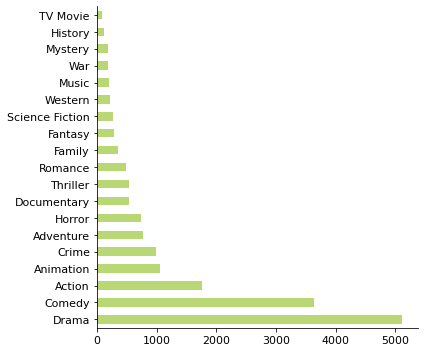

In [14]:
# Répartition des styles de films
plt.figure(figsize = (6,5))

ax = data_transformed['Categories_1'].value_counts().plot.barh(color = '#95C22D',
                                                                  alpha = 0.65,
                                                                  y = 'Catégorie')

ax.tick_params(axis = 'x', which = 'both', labelsize = 11)
ax.tick_params(axis = 'y', which = 'both', labelsize = 11)

for spine in ['top', 'right']:
            ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.savefig('Fig_2.png')

### Informations du casting du film (Genre des comédiens, noms, côte de popularité)
La colonne Cast contient énormément d'éléments. Pour mon algorithme, j'estime que le genre de l'acteur, son nom et sa côte de popularité (définie selon le site TMDb) me seront utiles. Sachant que pour le genre, 0 = inconnu, 1 = genre féminin, 2 = genre masculin et 3 = genre non-binaire. Je vais donc les extraire : 

In [15]:
# Définition d'une fonction pour extraire la liste de dictionnaires
def extract2(infos):
    list_infos_cast = ast.literal_eval(infos)
    gender = []
    name = []
    popularity = []
    if list_infos_cast :
        for i in list_infos_cast[0:3] :
             if i['gender'] > 0 :
                    if i['gender'] < 3 :
                        gender.append(i['gender'])
                        name.append(i['name'])
                        popularity.append(i['popularity'])
    return gender, name, popularity
    
# Je récupère dans une nouvelle colonne la liste des infos des acteurs
cast_info = data_transformed['Cast'].map(lambda x: extract2(x))

# Je place chaque catégorie d'info dans une colonne distincte
cast_info = pd.DataFrame(cast_info.to_list(), 
                         columns=['Cast_genres', 'Cast_names', 'Cast_pop'])

# Je divise chaque catégorie d'information en 3 colonnes
genre_cast = pd.DataFrame(cast_info['Cast_genres'].to_list(), columns=['Cast_genre_1', 'Cast_genre_2', 'Cast_genre_3'])
name_cast = pd.DataFrame(cast_info['Cast_names'].to_list(), columns=['Cast_names_1', 'Cast_names_2', 'Cast_names_3'])
pop_cast = pd.DataFrame(cast_info['Cast_pop'].to_list(), columns=['Cast_pop_1', 'Cast_pop_2', 'Cast_pop_3'])

# Je recolle mes deux dataframe
data_transformed = pd.concat([data_transformed, genre_cast, name_cast, pop_cast], axis = 1)

# Je vérifie qu'il n'y ait pas d'os dans le pâté
data_transformed.head()

TMDb_id  IMDB_id            Titre  \
0        6   107286   Judgment Night   
1       11    76759        Star Wars   
2       12   266543     Finding Nemo   
3       13   109830     Forrest Gump   
4       14   169547  American Beauty   

                                               Genre        Date Pays  \
0  [{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...  1993-10-15   JP   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 28, '...  1977-05-25   US   
2  [{'id': 16, 'name': 'Animation'}, {'id': 10751...  2003-05-30   US   
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...  1994-06-23   US   
4                      [{'id': 18, 'name': 'Drama'}]  1999-09-15   US   

   Runtime                                               Cast  \
0      109  [{'adult': False, 'gender': 2, 'id': 2880, 'kn...   
1      121  [{'adult': False, 'gender': 2, 'id': 2, 'known...   
2      100  [{'adult': False, 'gender': 2, 'id': 13, 'know...   
3      142  [{'adult': False, 'gender': 2, 'id': 31, 'know...   
4      122  [{'adult': False, 'gender': 2, 'id': 1979, 'kn...   

                                                Crew    Budget  ...  \
0  [{'adult': False, 'gender': 2, 'id': 2042, 'kn...  21000000  ...   
1  [{'adult': False, 'gender': 2, 'id': 1, 'known...  11000000  ...   
2  [{'adult': False, 'gender': 2, 'id': 7, 'known...  94000000  ...   
3  [{'adult': False, 'gender': 2, 'id': 37, 'know...  55000000  ...   
4  [{'adult': False, 'gender': 2, 'id': 153, 'kno...  15000000  ...   

      Categories_3  Cast_genre_1  Cast_genre_2 Cast_genre_3    Cast_names_1  \
0         Thriller           2.0           2.0          2.0  Emilio Estevez   
1  Science Fiction           2.0           2.0          1.0     Mark Hamill   
2             None           2.0           1.0          2.0   Albert Brooks   
3          Romance           2.0           1.0          2.0       Tom Hanks   
4             None           2.0           1.0          1.0    Kevin Spacey   

       Cast_names_2     Cast_names_3  Cast_pop_1  Cast_pop_2 Cast_pop_3  
0  Cuba Gooding Jr.      Denis Leary      21.128      12.177     16.471  
1     Harrison Ford    Carrie Fisher      25.625      48.790     18.209  
2   Ellen DeGeneres  Alexander Gould      18.191       7.028     11.130  
3      Robin Wright      Gary Sinise      83.406      36.321     14.801  
4    Annette Bening      Thora Birch      14.212      21.512     53.757  

[5 rows x 34 columns]

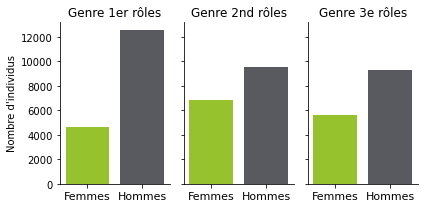

In [16]:
# Répartition des films selon les genres des acteurs
fig, ax = plt.subplots(1,3, figsize=(6,3), sharey = True)

sns.countplot(data_transformed['Cast_genre_1'],
              ax = ax[0],
              palette = ['#95C22D', '#595960'],
              saturation = 1).set(title = 'Genre 1er rôles')

sns.countplot(data_transformed['Cast_genre_2'],
              ax = ax[1],
              palette = ['#95C22D', '#595960'],
              saturation = 1).set(title = 'Genre 2nd rôles')

sns.countplot(data_transformed['Cast_genre_3'],
              ax = ax[2],
              palette = ['#95C22D', '#595960'],
              saturation = 1).set(title = 'Genre 3e rôles')

labels = ['Femmes', 'Hommes']
ax[0].set_xticklabels(labels, fontsize = 11)
ax[1].set_xticklabels(labels, fontsize = 11)
ax[2].set_xticklabels(labels, fontsize = 11)

ax[0].set(xlabel = '', ylabel = 'Nombre d\'individus')
ax[1].set(xlabel = '', ylabel = '')
ax[2].set(xlabel = '', ylabel = '')

for spine in ['top', 'right']:
            ax[0].spines[spine].set_visible(False)
            ax[1].spines[spine].set_visible(False)
            ax[2].spines[spine].set_visible(False)
        
fig.tight_layout()
plt.savefig('Fig_3.png')

### Informations du/de la réalisateur.trice (Genre, nom, côte de popularité)
Je récupère dans la colonne Crew le genre du/de la réalisateur.trice, son nom et sa côte de popularité (définie selon le site TMDb) :

In [17]:
# Je définis une fonction pour extraire la liste de dictionnaires du crew
    # et récupérer les informations du réalisateur (Genre, Nom, Popularité)
def extract3(infos):
    list_infos_director = ast.literal_eval(infos)
    gender = np.nan
    name = np.nan
    popularity = np.nan
    for i in list_infos_director :
        if i['job'] == 'Director' :
            if i['gender'] > 0 :
                if i['gender'] < 3 : 
                    gender = i['gender']
                    name = i['name']
                    popularity = i['popularity']
    return [gender, name, popularity]
        
# Je récupère dans une nouvelle colonne la liste des infos des acteurs
crew_info = data_transformed['Crew'].map(lambda x: extract3(x))

# Je place chaque catégorie d'info dans une colonne distincte
crew_info = pd.DataFrame(crew_info.to_list(), 
                        columns=['Genre_director', 'Name_director', 'Pop_director'])

# Je recolle mes deux dataframe
data_transformed = pd.concat([data_transformed, crew_info], axis = 1)

# Je vérifie qu'il n'y ait pas d'os dans le pâté
data_transformed.head()

TMDb_id  IMDB_id            Titre  \
0        6   107286   Judgment Night   
1       11    76759        Star Wars   
2       12   266543     Finding Nemo   
3       13   109830     Forrest Gump   
4       14   169547  American Beauty   

                                               Genre        Date Pays  \
0  [{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...  1993-10-15   JP   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 28, '...  1977-05-25   US   
2  [{'id': 16, 'name': 'Animation'}, {'id': 10751...  2003-05-30   US   
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...  1994-06-23   US   
4                      [{'id': 18, 'name': 'Drama'}]  1999-09-15   US   

   Runtime                                               Cast  \
0      109  [{'adult': False, 'gender': 2, 'id': 2880, 'kn...   
1      121  [{'adult': False, 'gender': 2, 'id': 2, 'known...   
2      100  [{'adult': False, 'gender': 2, 'id': 13, 'know...   
3      142  [{'adult': False, 'gender': 2, 'id': 31, 'know...   
4      122  [{'adult': False, 'gender': 2, 'id': 1979, 'kn...   

                                                Crew    Budget  ...  \
0  [{'adult': False, 'gender': 2, 'id': 2042, 'kn...  21000000  ...   
1  [{'adult': False, 'gender': 2, 'id': 1, 'known...  11000000  ...   
2  [{'adult': False, 'gender': 2, 'id': 7, 'known...  94000000  ...   
3  [{'adult': False, 'gender': 2, 'id': 37, 'know...  55000000  ...   
4  [{'adult': False, 'gender': 2, 'id': 153, 'kno...  15000000  ...   

   Cast_genre_3    Cast_names_1      Cast_names_2     Cast_names_3 Cast_pop_1  \
0           2.0  Emilio Estevez  Cuba Gooding Jr.      Denis Leary     21.128   
1           1.0     Mark Hamill     Harrison Ford    Carrie Fisher     25.625   
2           2.0   Albert Brooks   Ellen DeGeneres  Alexander Gould     18.191   
3           2.0       Tom Hanks      Robin Wright      Gary Sinise     83.406   
4           1.0    Kevin Spacey    Annette Bening      Thora Birch     14.212   

  Cast_pop_2 Cast_pop_3  Genre_director    Name_director Pop_director  
0     12.177     16.471             2.0  Stephen Hopkins        5.660  
1     48.790     18.209             2.0     George Lucas       14.387  
2      7.028     11.130             2.0   Andrew Stanton       22.113  
3     36.321     14.801             2.0  Robert Zemeckis       14.024  
4     21.512     53.757             2.0       Sam Mendes        7.849  

[5 rows x 37 columns]

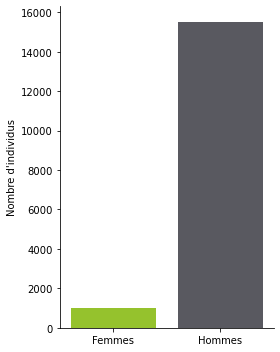

In [18]:
# Répartition des genres des réalisateur.trices
plt.figure(figsize = (4,5))

ax = sns.countplot(data_transformed['Genre_director'],
                  palette = ['#95C22D', '#595960'],
                  saturation = 1)

labels = ['Femmes', 'Hommes']
ax.set_xticklabels(labels)
ax.set(xlabel = '', ylabel = 'Nombre d\'individus')

for spine in ['top', 'right']:
            ax.spines[spine].set_visible(False)

plt.tight_layout()          
plt.savefig('Fig_4.png')

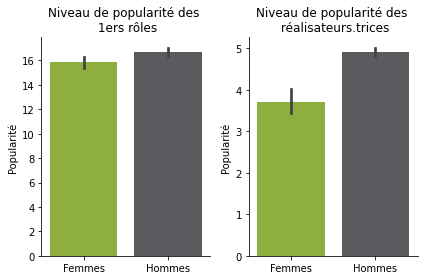

In [19]:
# Répartition des genres selon la popularité
fig, ax = plt.subplots(1,2, figsize = (6,4))

# Popularité casting
_ = sns.barplot(ax = ax[0],
                data = data_transformed,
                x = 'Cast_genre_1',
                y = 'Cast_pop_1',
                palette = ['#95C22D', '#595960']).set_title('Niveau de popularité des \n 1ers rôles')

# Popularité réalisateur.trice
_ = sns.barplot(ax = ax[1],
                data = data_transformed,
                x = 'Genre_director',
                y = 'Pop_director',
                palette = ['#95C22D', '#595960']).set_title('Niveau de popularité des \n réalisateurs.trices')

labels = ['Femmes', 'Hommes']
_ = ax[0].set_xticklabels(labels)
_ = ax[1].set_xticklabels(labels)

_ = ax[0].set(xlabel = '', ylabel = 'Popularité')
_ = ax[1].set(xlabel = '', ylabel = 'Popularité')

for spine in ['top', 'right']:
            ax[0].spines[spine].set_visible(False)
            ax[1].spines[spine].set_visible(False)
            
plt.tight_layout()  
plt.savefig('Fig_5.png')

### Mots-clés des différents films
J'extrais la colonne Keywords contenant les différents mots clés afin de décrire et catégoriser au mieux chaque film :

In [20]:
# Je définis une fonction pour extraire la liste de dictionnaires des Keywords
    # et récupérer les différents mots clés
def extract4(keywords):
    list_keywords = ast.literal_eval(keywords)
    motscles = []
    if list_keywords : 
        for i in list_keywords[0:3] : 
            motscles.append(i['name'])
    return motscles

# Je récupère dans une nouvelle variable la liste des infos des acteurs
all_keywords = data_transformed['Keywords'].map(lambda x: extract4(x))
all_keywords = pd.DataFrame(all_keywords)

# Je place chaque mot clé dans une colonne distincte
mots_cles = pd.DataFrame(all_keywords['Keywords'].to_list(), columns=['Mots_cles_1', 'Mots_cles_2', 'Mots_cles_3'])

# Je recolle mes deux dataframe
data_transformed = pd.concat([data_transformed, mots_cles], axis = 1)

# Je vérifie qu'il n'y ait pas d'os dans le pâté
data_transformed.head()

TMDb_id  IMDB_id            Titre  \
0        6   107286   Judgment Night   
1       11    76759        Star Wars   
2       12   266543     Finding Nemo   
3       13   109830     Forrest Gump   
4       14   169547  American Beauty   

                                               Genre        Date Pays  \
0  [{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...  1993-10-15   JP   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 28, '...  1977-05-25   US   
2  [{'id': 16, 'name': 'Animation'}, {'id': 10751...  2003-05-30   US   
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...  1994-06-23   US   
4                      [{'id': 18, 'name': 'Drama'}]  1999-09-15   US   

   Runtime                                               Cast  \
0      109  [{'adult': False, 'gender': 2, 'id': 2880, 'kn...   
1      121  [{'adult': False, 'gender': 2, 'id': 2, 'known...   
2      100  [{'adult': False, 'gender': 2, 'id': 13, 'know...   
3      142  [{'adult': False, 'gender': 2, 'id': 31, 'know...   
4      122  [{'adult': False, 'gender': 2, 'id': 1979, 'kn...   

                                                Crew    Budget  ...  \
0  [{'adult': False, 'gender': 2, 'id': 2042, 'kn...  21000000  ...   
1  [{'adult': False, 'gender': 2, 'id': 1, 'known...  11000000  ...   
2  [{'adult': False, 'gender': 2, 'id': 7, 'known...  94000000  ...   
3  [{'adult': False, 'gender': 2, 'id': 37, 'know...  55000000  ...   
4  [{'adult': False, 'gender': 2, 'id': 153, 'kno...  15000000  ...   

      Cast_names_3  Cast_pop_1  Cast_pop_2 Cast_pop_3 Genre_director  \
0      Denis Leary      21.128      12.177     16.471            2.0   
1    Carrie Fisher      25.625      48.790     18.209            2.0   
2  Alexander Gould      18.191       7.028     11.130            2.0   
3      Gary Sinise      83.406      36.321     14.801            2.0   
4      Thora Birch      14.212      21.512     53.757            2.0   

     Name_director Pop_director                Mots_cles_1  \
0  Stephen Hopkins        5.660          chicago, illinois   
1     George Lucas       14.387                    android   
2   Andrew Stanton       22.113  parent child relationship   
3  Robert Zemeckis       14.024            vietnam veteran   
4       Sam Mendes        7.849                   adultery   

                 Mots_cles_2         Mots_cles_3  
0                drug dealer              escape  
1                     galaxy              hermit  
2          sydney, australia              harbor  
3                     hippie  washington dc, usa  
4  parent child relationship      midlife crisis  

[5 rows x 40 columns]

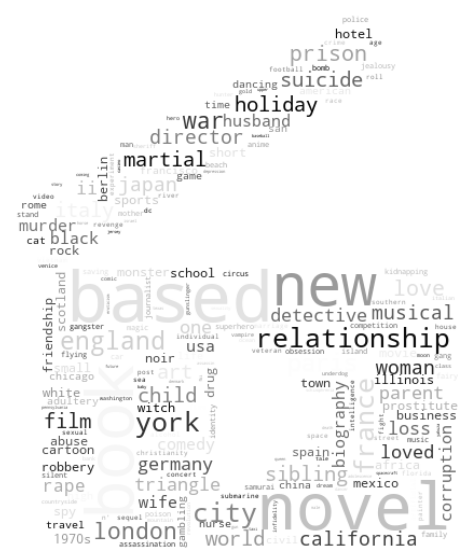

In [21]:
# Je crée un texte avec nos mots clés
texte = " ".join(title for title in data_transformed['Mots_cles_1'].dropna().astype(str))

mask = np.array(Image.open('/Users/justine.facchini/Sans titre - 1.png'))

# Je crée un nuage de mots provenant du texte créé
stopwords = set(STOPWORDS)
word_cloud = WordCloud(collocations = False, 
                        stopwords = stopwords, 
                        background_color = 'white',
                        colormap = 'gray',
                        mask = mask,
                        width = 2048, height = 1080).generate(texte)

# J'affiche le nuage de mots
_ = plt.figure(figsize = (10,10))
_ = plt.imshow(word_cloud, interpolation = "bilinear")
_ = plt.axis("off")
_ = plt.savefig('Fig_6.png')

# Je récupère les id des collections de films
Certains films ont des suites (Matrix, Star Wars, Nemo, ...). Logiquement, si une personne a aimé un film elle aimera voir les suites ; le système de recommandation doit donc pouvoir les lui recommander :

In [22]:
# Je définis une fonction pour extraire la liste de dictionnaires des collections de films
    # et récupérer les informations et les id des autres films
def collec(liste):
    if pd.isna(liste) : 
        return np.nan
    else : 
        collec_films = []
        liste_collec = ast.literal_eval(liste)
        for i in liste_collec :
            collec_films.append(i['id'])
        return collec_films

# Je récupère dans une nouvelle variable la liste des index des suites
data_transformed['Collec_films'] = data_transformed['Films_Collection'].map(lambda x: collec(x))

# Je vérifie qu'il n'y ait pas d'os dans le pâté
data_transformed.head()

TMDb_id  IMDB_id            Titre  \
0        6   107286   Judgment Night   
1       11    76759        Star Wars   
2       12   266543     Finding Nemo   
3       13   109830     Forrest Gump   
4       14   169547  American Beauty   

                                               Genre        Date Pays  \
0  [{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...  1993-10-15   JP   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 28, '...  1977-05-25   US   
2  [{'id': 16, 'name': 'Animation'}, {'id': 10751...  2003-05-30   US   
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...  1994-06-23   US   
4                      [{'id': 18, 'name': 'Drama'}]  1999-09-15   US   

   Runtime                                               Cast  \
0      109  [{'adult': False, 'gender': 2, 'id': 2880, 'kn...   
1      121  [{'adult': False, 'gender': 2, 'id': 2, 'known...   
2      100  [{'adult': False, 'gender': 2, 'id': 13, 'know...   
3      142  [{'adult': False, 'gender': 2, 'id': 31, 'know...   
4      122  [{'adult': False, 'gender': 2, 'id': 1979, 'kn...   

                                                Crew    Budget  ...  \
0  [{'adult': False, 'gender': 2, 'id': 2042, 'kn...  21000000  ...   
1  [{'adult': False, 'gender': 2, 'id': 1, 'known...  11000000  ...   
2  [{'adult': False, 'gender': 2, 'id': 7, 'known...  94000000  ...   
3  [{'adult': False, 'gender': 2, 'id': 37, 'know...  55000000  ...   
4  [{'adult': False, 'gender': 2, 'id': 153, 'kno...  15000000  ...   

   Cast_pop_1  Cast_pop_2  Cast_pop_3 Genre_director    Name_director  \
0      21.128      12.177      16.471            2.0  Stephen Hopkins   
1      25.625      48.790      18.209            2.0     George Lucas   
2      18.191       7.028      11.130            2.0   Andrew Stanton   
3      83.406      36.321      14.801            2.0  Robert Zemeckis   
4      14.212      21.512      53.757            2.0       Sam Mendes   

  Pop_director                Mots_cles_1                Mots_cles_2  \
0        5.660          chicago, illinois                drug dealer   
1       14.387                    android                     galaxy   
2       22.113  parent child relationship          sydney, australia   
3       14.024            vietnam veteran                     hippie   
4        7.849                   adultery  parent child relationship   

          Mots_cles_3                                       Collec_films  
0              escape                                                NaN  
1              hermit  [11, 1891, 1892, 1893, 1894, 1895, 140607, 181...  
2              harbor                                       [12, 127380]  
3  washington dc, usa                                                NaN  
4      midlife crisis                                                NaN  

[5 rows x 41 columns]

Maintenant que j'ai nettoyé mon dataset et extrait les informations pertinentes, je crée un nouveau dataframe en enlevant les colonnes qui n'ont plus d'intérêt :

In [23]:
data_cleaned = data_transformed.drop(['IMDB_id',
                                      'Genre', 
                                      'Date', 
                                      'Pays', 
                                      'Cast', 
                                      'Crew', 
                                      'Note',
                                      'Nb_notes',
                                      'Collection', 
                                      'Films_Collection',
                                      'Keywords',
                                      'Année'], axis = 1).copy()
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17521 entries, 0 to 17520
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TMDb_id         17521 non-null  int64  
 1   Titre           17521 non-null  object 
 2   Runtime         17521 non-null  int64  
 3   Budget          17521 non-null  int64  
 4   Revenue         17521 non-null  int64  
 5   Poster          17521 non-null  object 
 6   Bechdel         4405 non-null   float64
 7   Note_pondérée   17521 non-null  float64
 8   Decade          17521 non-null  int64  
 9   Regions         14213 non-null  object 
 10  Categories_1    17518 non-null  object 
 11  Categories_2    13561 non-null  object 
 12  Categories_3    7540 non-null   object 
 13  Cast_genre_1    17160 non-null  float64
 14  Cast_genre_2    16448 non-null  float64
 15  Cast_genre_3    14937 non-null  float64
 16  Cast_names_1    17160 non-null  object 
 17  Cast_names_2    16448 non-null 

In [24]:
# Et je supprime les lignes où les informations cruciales sont manquantes :
data_cleaned.dropna(axis = 0,
                    how = 'any',
                    subset = ['Regions', 'Categories_1',
                              'Cast_genre_1', 'Cast_names_1',
                              'Cast_pop_1', 'Mots_cles_1',
                              'Genre_director', 'Name_director',
                              'Pop_director', 'Note_pondérée'],
                    inplace = True)
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11711 entries, 0 to 17520
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TMDb_id         11711 non-null  int64  
 1   Titre           11711 non-null  object 
 2   Runtime         11711 non-null  int64  
 3   Budget          11711 non-null  int64  
 4   Revenue         11711 non-null  int64  
 5   Poster          11711 non-null  object 
 6   Bechdel         3650 non-null   float64
 7   Note_pondérée   11711 non-null  float64
 8   Decade          11711 non-null  int64  
 9   Regions         11711 non-null  object 
 10  Categories_1    11711 non-null  object 
 11  Categories_2    9406 non-null   object 
 12  Categories_3    5454 non-null   object 
 13  Cast_genre_1    11711 non-null  float64
 14  Cast_genre_2    11350 non-null  float64
 15  Cast_genre_3    10508 non-null  float64
 16  Cast_names_1    11711 non-null  object 
 17  Cast_names_2    11350 non-null 

# La macchina à recommandations

J'ai choisis de construire mon algorithme de recommandation selon différents paramètres comme l'année, le pays, le type de film, le nom des acteurs ou du réalisateur, ou encore les mots-clés associés au film. D'après ces paramètres, l'algorithme définira des similarités avec d'autres films afin de les recommander :

In [25]:
# Je transforme tout mon dataframe en chaîne de caractère
data_cleaned = data_cleaned.astype(str)

# Je crée une "soupe" contenant les différents paramètres qui vont m'intéresser pour ma recommandation
def create_soup(x):
    return (' ' + x['Decade'] + (' ' + x['Regions']) + 
            (' ' + x['Categories_1']) +  (' ' + x['Categories_2']) + 
            (' ' + x['Categories_3']) +  (' ' + x['Cast_names_1']) + 
            (' ' + x['Cast_names_2']) +  (' ' + x['Cast_names_3']) + 
            (' ' + x['Name_director']) +  (' ' + x['Mots_cles_1']) + 
            (' ' + x['Mots_cles_2']) +  (' ' + x['Mots_cles_3']))

# Je crée une nouvelle colonne contenant ma soupe
data_cleaned['soup'] = data_cleaned.apply(create_soup, axis=1)

# J'obtiens ainsi une phrase contenant tous les éléments essentiels à ma recommandation
data_cleaned['soup'].iloc[0]

' 1990 Asie Action Crime Thriller Emilio Estevez Cuba Gooding Jr. Denis Leary Stephen Hopkins chicago, illinois drug dealer escape'

J'ai choisi d'employer une technique de Natural Language Processing (NLP) pour construire mon algorithme. J'ai au préalable créé une phrase propre à chaque film contenant tous les éléments nécessaires à le décrire.
J'utilise ensuite un CountVectorizer qui me permet de vectoriser chaque mot de ma phrase et qui crée une matrice où chaque mot est représenté dans une colonne. A la fin, chaque cellule contiendra une valeur correspondant au nombre de fois où le mot apparaît dans cette phrase.

In [26]:
# Je vectorise et compte chaque mot de ma phrase
count = CountVectorizer(stop_words = 'english')
count_matrix = count.fit_transform(data_cleaned['soup'])

Sur la base de cette matrice, j'effectue ensuite une Cosine Similarity. L'objectif est de mesurer la similarité entre deux séquences de nombres :

In [27]:
# J'applique ma cosine similarity sur la matrice que j'ai créée
cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [28]:
# Je réinitialise l'index de mon DataFrame 
data_cleaned = data_cleaned.reset_index(drop = True)
indices = pd.Series(data_cleaned.index, index = data_cleaned['TMDb_id'])

In [29]:
def get_recommendations(title, cosine_sim = cosine_sim2):
    #nb_index = data_cleaned.loc[data_cleaned['Titre'] == title, 'TMDb_id'].iloc[0]
    # Récupère l'index du film selon son titre
    index = indices[title]

    # Récupère le score de similarité de tous les films associés au film recherché
    score_sim = list(enumerate(cosine_sim[index]))

    # Trie les films selon le score de similarité décroissant
    score_sim = sorted(score_sim, key = lambda x: x[1], reverse = True)

    # Récupère le score des 30 films similaires
    score_sim = score_sim[1:31]

    # Récupère l'indice du film
    movie_indices = [i[0] for i in score_sim]

    # Retourne les 30 meilleurs films similaires
    return data_cleaned['Titre'].iloc[movie_indices]           

### Recommandation #1

In [51]:
data_cleaned.loc[data_cleaned['Titre'] == 'Kill Bill: Vol. 1']

TMDb_id              Titre Runtime    Budget    Revenue  \
9      24  Kill Bill: Vol. 1     111  30000000  180906076   

                                              Poster Bechdel  \
9  https://image.tmdb.org/t/p/w185/v7TaX8kXMXs5yF...     3.0   

       Note_pondérée Decade         Regions  ... Cast_pop_2 Cast_pop_3  \
9  7.934162192623727   2000  Nord Américain  ...     41.763     14.629   

  Genre_director      Name_director Pop_director Mots_cles_1 Mots_cles_2  \
9            2.0  Quentin Tarantino       33.283       japan        coma   

    Mots_cles_3 Collec_films  \
9  martial arts    [24, 393]   

                                                soup  
9   2000 Nord Américain Action Crime None Uma Thu...  

[1 rows x 30 columns]

In [54]:
index_films_reco = get_recommendations('24', cosine_sim2).index
index_films_reco

Int64Index([ 4731,   210,  1311, 10312,   155,   372,   816,  7011,  9497,
             1089,  1090,  1583,  1300,  5237,   772,   991,  2086,  2598,
             2612,  2838,  3473,  4194,  4452,  6729,   621,   806,  1195,
             1231,  1504,  2675],
           dtype='int64')

In [55]:
initial_reco = (data_cleaned.loc[index_films_reco, 
                         ['Titre','Bechdel', 
                          'Cast_genre_1', 
                          'Genre_director', 
                          'Poster', 
                          'Note_pondérée']])

initial_reco

Titre Bechdel Cast_genre_1  \
4731           Kill Bill: The Whole Bloody Affair     nan          1.0   
210                             Kill Bill: Vol. 2     3.0          1.0   
1311                                Shanghai Noon     1.0          2.0   
10312                       Sister Street Fighter     nan          1.0   
155                                 Batman Begins     1.0          2.0   
372                                  Pulp Fiction     3.0          2.0   
816                            Kiss of the Dragon     1.0          2.0   
7011                         Revenge of the Ninja     nan          2.0   
9497                           The Street Fighter     nan          2.0   
1089                                  Rush Hour 3     nan          2.0   
1090                                  Rush Hour 2     3.0          2.0   
1583                               Demolition Man     0.0          2.0   
1300                              Never Back Down     2.0          2.0   
5237                                   Avengement     nan          2.0   
772                                   Death Proof     3.0          2.0   
991                                    Black Rain     nan          2.0   
2086                      The Long Kiss Goodnight     3.0          1.0   
2598                            Lone Wolf McQuade     nan          2.0   
2612                                   Undisputed     nan          2.0   
2838                                      In Hell     0.0          2.0   
3473                    The Powerpuff Girls Movie     3.0          1.0   
4194                                   Grindhouse     nan          1.0   
4452                              The Equalizer 2     nan          2.0   
6729                   Afro Samurai: Resurrection     nan          2.0   
621                    Curse of the Golden Flower     2.0          2.0   
806                                     Rush Hour     1.0          2.0   
1195                                  Equilibrium     1.0          2.0   
1231                           Behind Enemy Lines     0.0          2.0   
1504                                Kung Fu Panda     3.0          2.0   
2675   Kung Fu Panda: Secrets of the Furious Five     nan          2.0   

      Genre_director                                             Poster  \
4731             2.0  https://image.tmdb.org/t/p/w185/zomX76Pf3nUaTz...   
210              2.0  https://image.tmdb.org/t/p/w185/2yhg0mZQMhDyvU...   
1311             2.0  https://image.tmdb.org/t/p/w185/b0WwWRcDiDahka...   
10312            2.0  https://image.tmdb.org/t/p/w185/3pDkPHMqSXA69j...   
155              2.0  https://image.tmdb.org/t/p/w185/4MpN4kIEqUjW8O...   
372              2.0  https://image.tmdb.org/t/p/w185/fIE3lAGcZDV1G6...   
816              2.0  https://image.tmdb.org/t/p/w185/A1GrGdX4AgCRDw...   
7011             2.0  https://image.tmdb.org/t/p/w185/qEZ0Av3VvJvIs0...   
9497             2.0  https://image.tmdb.org/t/p/w185/ziesmAcMcUPnsG...   
1089             2.0  https://image.tmdb.org/t/p/w185/rZ7IxJlPhNNJ6R...   
1090             2.0  https://image.tmdb.org/t/p/w185/aBQf2vMiCINeVC...   
1583             2.0  https://image.tmdb.org/t/p/w185/49GjSZn9FnSnrR...   
1300             2.0  https://image.tmdb.org/t/p/w185/8oRUTyP1QAtGDM...   
5237             2.0  https://image.tmdb.org/t/p/w185/rXPxSAYf3FdQkt...   
772              2.0  https://image.tmdb.org/t/p/w185/vtu6H4NWnQVqEp...   
991              2.0  https://image.tmdb.org/t/p/w185/funhGWt9ee3Uwb...   
2086             2.0  https://image.tmdb.org/t/p/w185/yREdXX5lMFUKhT...   
2598             2.0  https://image.tmdb.org/t/p/w185/dTUTDPilI2Ozi5...   
2612             2.0  https://image.tmdb.org/t/p/w185/xgnCABtbMDaDqn...   
2838             2.0  https://image.tmdb.org/t/p/w185/vE2fYcP07fbIHo...   
3473             2.0  https://image.tmdb.org/t/p/w185/fYQIXrPHtYSSBm...   
4194             2.0  https://image.tmdb.org/t/p/w185/jl3K6T8Mridd2d...   
4452             2.0  ht

In [57]:
bechdel = initial_reco.replace('nan', np.nan).dropna(how = 'any',
                    subset = ['Bechdel'],
                    inplace = False).sort_values(by = 'Bechdel', ascending = False).iloc[0:10]
bechdel

Titre Bechdel Cast_genre_1 Genre_director  \
210            Kill Bill: Vol. 2     3.0          1.0            2.0   
1090                 Rush Hour 2     3.0          2.0            2.0   
3473   The Powerpuff Girls Movie     3.0          1.0            2.0   
2086     The Long Kiss Goodnight     3.0          1.0            2.0   
772                  Death Proof     3.0          2.0            2.0   
372                 Pulp Fiction     3.0          2.0            2.0   
1504               Kung Fu Panda     3.0          2.0            2.0   
1300             Never Back Down     2.0          2.0            2.0   
621   Curse of the Golden Flower     2.0          2.0            2.0   
816           Kiss of the Dragon     1.0          2.0            2.0   

                                                 Poster      Note_pondérée  
210   https://image.tmdb.org/t/p/w185/2yhg0mZQMhDyvU...  7.837203895972822  
1090  https://image.tmdb.org/t/p/w185/aBQf2vMiCINeVC...  6.644207311226527  
3473  https://image.tmdb.org/t/p/w185/fYQIXrPHtYSSBm...  6.422775763176707  
2086  https://image.tmdb.org/t/p/w185/yREdXX5lMFUKhT...  6.538390878261625  
772   https://image.tmdb.org/t/p/w185/vtu6H4NWnQVqEp...  6.785835527463789  
372   https://image.tmdb.org/t/p/w185/fIE3lAGcZDV1G6...  8.458779750380819  
1504  https://image.tmdb.org/t/p/w185/xCn3VOST64XpOA...  7.176644012776131  
1300  https://image.tmdb.org/t/p/w185/8oRUTyP1QAtGDM...  6.649665934449159  
621   https://image.tmdb.org/t/p/w185/cuX11HZlkNFHCi...  6.614588085303037  
816   https://image.tmdb.org/t/p/w185/A1GrGdX4AgCRDw...  6.691078951450594

In [58]:
genre_1st_role = initial_reco.replace('nan', np.nan).dropna(how = 'any',
                    subset = ['Cast_genre_1'],
                    inplace = False).sort_values(by = 'Cast_genre_1', ascending = True).iloc[0:10]
genre_1st_role

Titre Bechdel Cast_genre_1 Genre_director  \
4731   Kill Bill: The Whole Bloody Affair     NaN          1.0            2.0   
210                     Kill Bill: Vol. 2     3.0          1.0            2.0   
10312               Sister Street Fighter     NaN          1.0            2.0   
4194                           Grindhouse     NaN          1.0            2.0   
3473            The Powerpuff Girls Movie     3.0          1.0            2.0   
2086              The Long Kiss Goodnight     3.0          1.0            2.0   
1231                   Behind Enemy Lines     0.0          2.0            2.0   
1195                          Equilibrium     1.0          2.0            2.0   
806                             Rush Hour     1.0          2.0            2.0   
621            Curse of the Golden Flower     2.0          2.0            2.0   

                                                  Poster      Note_pondérée  
4731   https://image.tmdb.org/t/p/w185/zomX76Pf3nUaTz...  7.483173972112385  
210    https://image.tmdb.org/t/p/w185/2yhg0mZQMhDyvU...  7.837203895972822  
10312  https://image.tmdb.org/t/p/w185/3pDkPHMqSXA69j...   6.36557740536707  
4194   https://image.tmdb.org/t/p/w185/jl3K6T8Mridd2d...  6.852834811511812  
3473   https://image.tmdb.org/t/p/w185/fYQIXrPHtYSSBm...  6.422775763176707  
2086   https://image.tmdb.org/t/p/w185/yREdXX5lMFUKhT...  6.538390878261625  
1231   https://image.tmdb.org/t/p/w185/fZReMWU3zszvak...  6.294302617700862  
1195   https://image.tmdb.org/t/p/w185/yQuovle5Ov6q69...  6.963999014437576  
806    https://image.tmdb.org/t/p/w185/we7wOLVFgxhzLz...  6.922711810495993  
621    https://image.tmdb.org/t/p/w185/cuX11HZlkNFHCi...  6.614588085303037

In [59]:
genre_director = initial_reco.replace('nan', np.nan).dropna(how = 'any',
                    subset = ['Genre_director'],
                    inplace = False).sort_values(by = 'Genre_director', ascending = True).iloc[0:10]
genre_director

Titre Bechdel Cast_genre_1 Genre_director  \
4731  Kill Bill: The Whole Bloody Affair     NaN          1.0            2.0   
1231                  Behind Enemy Lines     0.0          2.0            2.0   
1195                         Equilibrium     1.0          2.0            2.0   
806                            Rush Hour     1.0          2.0            2.0   
621           Curse of the Golden Flower     2.0          2.0            2.0   
6729          Afro Samurai: Resurrection     NaN          2.0            2.0   
4452                     The Equalizer 2     NaN          2.0            2.0   
4194                          Grindhouse     NaN          1.0            2.0   
3473           The Powerpuff Girls Movie     3.0          1.0            2.0   
2838                             In Hell     0.0          2.0            2.0   

                                                 Poster      Note_pondérée  
4731  https://image.tmdb.org/t/p/w185/zomX76Pf3nUaTz...  7.483173972112385  
1231  https://image.tmdb.org/t/p/w185/fZReMWU3zszvak...  6.294302617700862  
1195  https://image.tmdb.org/t/p/w185/yQuovle5Ov6q69...  6.963999014437576  
806   https://image.tmdb.org/t/p/w185/we7wOLVFgxhzLz...  6.922711810495993  
621   https://image.tmdb.org/t/p/w185/cuX11HZlkNFHCi...  6.614588085303037  
6729  https://image.tmdb.org/t/p/w185/6snrLj3Ydmbu5L...  6.536501021120063  
4452  https://image.tmdb.org/t/p/w185/cQvc9N6JiMVKqo...  6.618238079716582  
4194  https://image.tmdb.org/t/p/w185/jl3K6T8Mridd2d...  6.852834811511812  
3473  https://image.tmdb.org/t/p/w185/fYQIXrPHtYSSBm...  6.422775763176707  
2838  https://image.tmdb.org/t/p/w185/vE2fYcP07fbIHo...   6.38685441900985

Je récupère les 3 DataFrame pour en faire une recommandation finale :

In [60]:
# Je les trie de sorte à faire remonter les films où le premier rôle est féminin
biaised_reco = (pd.concat([bechdel, 
                         genre_1st_role, 
                         genre_director], axis = 0).sort_values(by = 'Cast_genre_1', 
                                                                ascending = True))

# Je supprime les éventuels doublons
biaised_reco.drop_duplicates(inplace = True)

Je compare maintenant ma recommandation initale avec ma recommandation biasiée :

In [61]:
initial_reco[0:10]

Titre Bechdel Cast_genre_1 Genre_director  \
4731   Kill Bill: The Whole Bloody Affair     nan          1.0            2.0   
210                     Kill Bill: Vol. 2     3.0          1.0            2.0   
1311                        Shanghai Noon     1.0          2.0            2.0   
10312               Sister Street Fighter     nan          1.0            2.0   
155                         Batman Begins     1.0          2.0            2.0   
372                          Pulp Fiction     3.0          2.0            2.0   
816                    Kiss of the Dragon     1.0          2.0            2.0   
7011                 Revenge of the Ninja     nan          2.0            2.0   
9497                   The Street Fighter     nan          2.0            2.0   
1089                          Rush Hour 3     nan          2.0            2.0   

                                                  Poster       Note_pondérée  
4731   https://image.tmdb.org/t/p/w185/zomX76Pf3nUaTz...   7.483173972112385  
210    https://image.tmdb.org/t/p/w185/2yhg0mZQMhDyvU...   7.837203895972822  
1311   https://image.tmdb.org/t/p/w185/b0WwWRcDiDahka...   6.391918910280634  
10312  https://image.tmdb.org/t/p/w185/3pDkPHMqSXA69j...    6.36557740536707  
155    https://image.tmdb.org/t/p/w185/4MpN4kIEqUjW8O...   7.670994138208449  
372    https://image.tmdb.org/t/p/w185/fIE3lAGcZDV1G6...   8.458779750380819  
816    https://image.tmdb.org/t/p/w185/A1GrGdX4AgCRDw...   6.691078951450594  
7011   https://image.tmdb.org/t/p/w185/qEZ0Av3VvJvIs0...    6.34463202572007  
9497   https://image.tmdb.org/t/p/w185/ziesmAcMcUPnsG...  6.4409546068143815  
1089   https://image.tmdb.org/t/p/w185/rZ7IxJlPhNNJ6R...    6.40632214963889

In [62]:
biaised_reco[0:10]

Titre Bechdel Cast_genre_1 Genre_director  \
210                     Kill Bill: Vol. 2     3.0          1.0            2.0   
4194                           Grindhouse     NaN          1.0            2.0   
4731   Kill Bill: The Whole Bloody Affair     NaN          1.0            2.0   
2086              The Long Kiss Goodnight     3.0          1.0            2.0   
3473            The Powerpuff Girls Movie     3.0          1.0            2.0   
10312               Sister Street Fighter     NaN          1.0            2.0   
621            Curse of the Golden Flower     2.0          2.0            2.0   
1090                          Rush Hour 2     3.0          2.0            2.0   
4452                      The Equalizer 2     NaN          2.0            2.0   
6729           Afro Samurai: Resurrection     NaN          2.0            2.0   

                                                  Poster      Note_pondérée  
210    https://image.tmdb.org/t/p/w185/2yhg0mZQMhDyvU...  7.837203895972822  
4194   https://image.tmdb.org/t/p/w185/jl3K6T8Mridd2d...  6.852834811511812  
4731   https://image.tmdb.org/t/p/w185/zomX76Pf3nUaTz...  7.483173972112385  
2086   https://image.tmdb.org/t/p/w185/yREdXX5lMFUKhT...  6.538390878261625  
3473   https://image.tmdb.org/t/p/w185/fYQIXrPHtYSSBm...  6.422775763176707  
10312  https://image.tmdb.org/t/p/w185/3pDkPHMqSXA69j...   6.36557740536707  
621    https://image.tmdb.org/t/p/w185/cuX11HZlkNFHCi...  6.614588085303037  
1090   https://image.tmdb.org/t/p/w185/aBQf2vMiCINeVC...  6.644207311226527  
4452   https://image.tmdb.org/t/p/w185/cQvc9N6JiMVKqo...  6.618238079716582  
6729   https://image.tmdb.org/t/p/w185/6snrLj3Ydmbu5L...  6.536501021120063

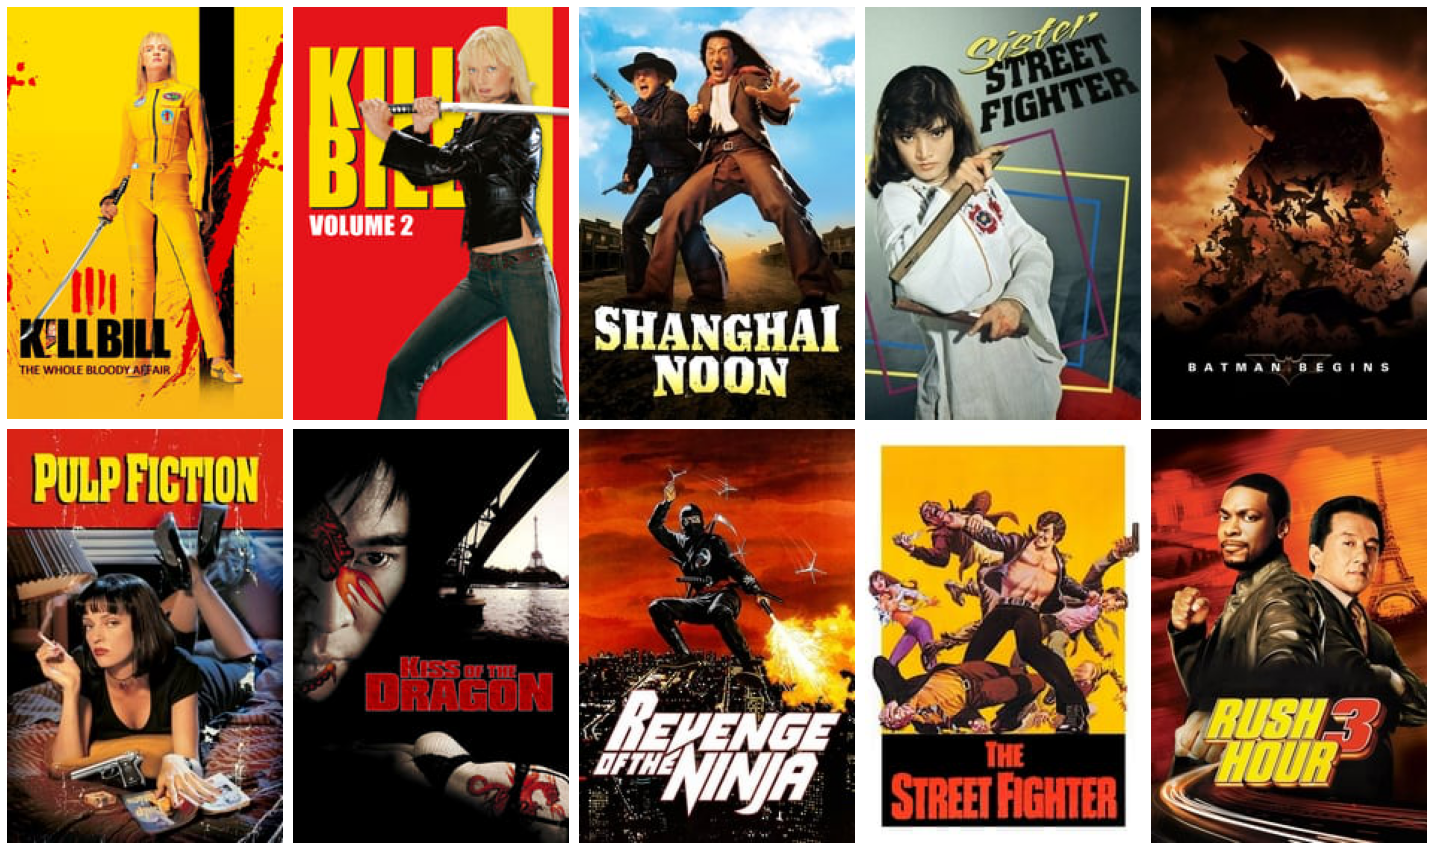

In [63]:
# Poster final_reco
fig, ax = plt.subplots(2,5, figsize = (20, 12))

for i in range(10) :
    url = initial_reco['Poster'].iloc[i]
    urllib.request.urlretrieve(url, 'youpla.png')
    img = Image.open('youpla.png')
    if i < 5 :
        ax[0, i].imshow(img)
        ax[0, i].axis('off')
    else :
        ax[1, i-5].imshow(img)
        ax[1, i-5].axis('off')

fig.tight_layout()  
fig.savefig('Fig_6.png')

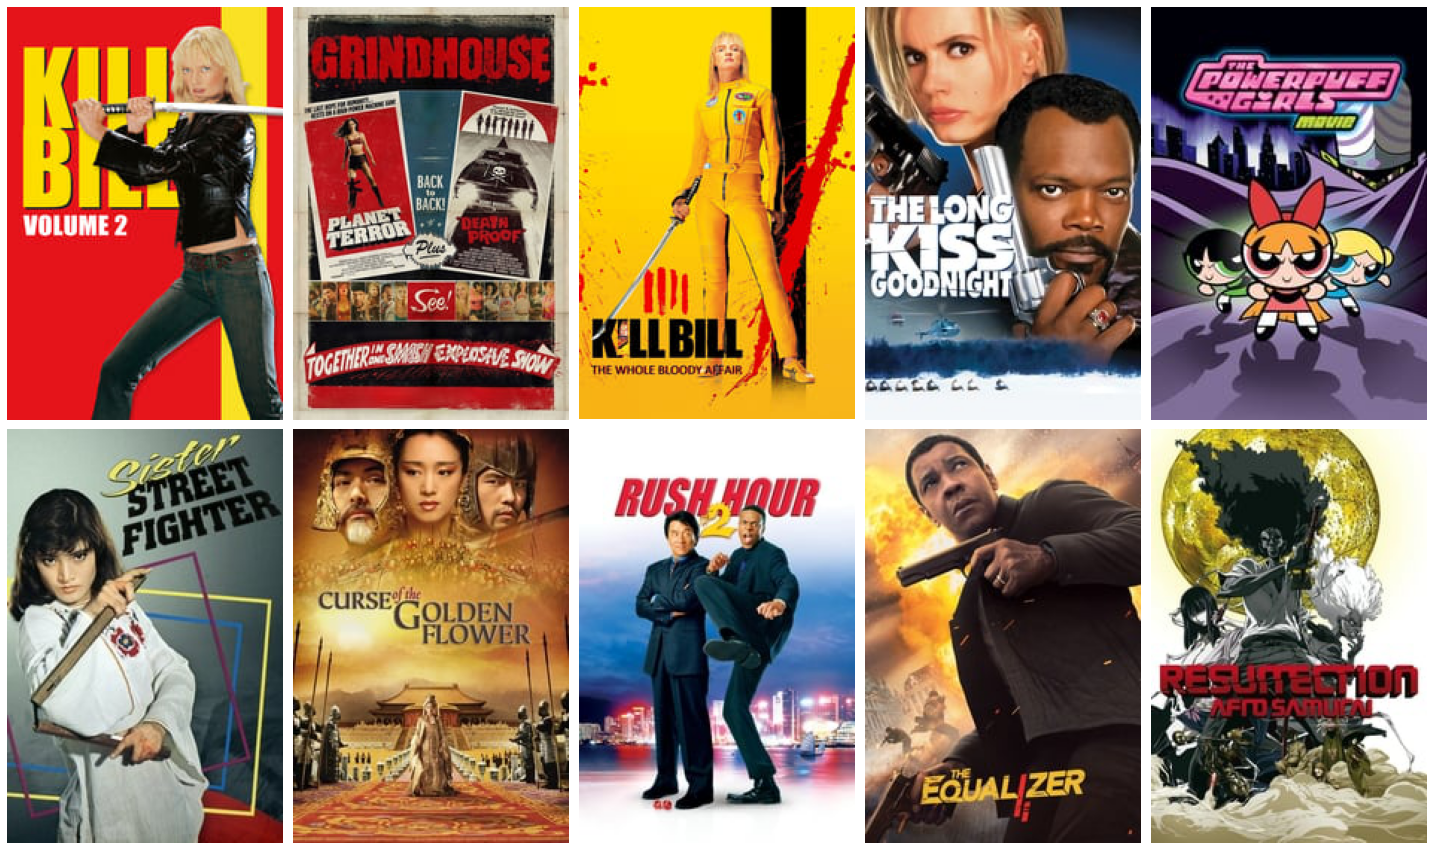

In [64]:
# Poster final_reco
fig, ax = plt.subplots(2,5, figsize = (20, 12))

for i in range(10) :
    url = biaised_reco['Poster'].iloc[i]
    urllib.request.urlretrieve(url, 'youpla.png')
    img = Image.open('youpla.png')
    if i < 5 :
        ax[0, i].imshow(img)
        ax[0, i].axis('off')
    else :
        ax[1, i-5].imshow(img)
        ax[1, i-5].axis('off')

fig.tight_layout()  
fig.savefig('Fig_7.png')

Je représente graphiquement l'effet de mon biais :

In [65]:
# Je récupère les moyennes de chaque paramètre
bechdel_final = initial_reco['Bechdel'].iloc[0:10]
biais_bechdel_final = biaised_reco['Bechdel'].iloc[0:10]
cast_genre_final = initial_reco['Cast_genre_1'].iloc[0:10]
biais_cast_genre_final = biaised_reco['Cast_genre_1'].iloc[0:10]
genre_director_final = initial_reco['Genre_director'].iloc[0:10]
biais_genre_director_final = biaised_reco['Genre_director'].iloc[0:10]

all_metrics = [bechdel_final.to_list(),
               biais_bechdel_final.to_list(),
               cast_genre_final.to_list(),
               biais_cast_genre_final.to_list(), 
               genre_director_final.to_list(),
               biais_genre_director_final.to_list()]

# Je mets toutes ces moyennes en forme de DataFrame
metrics = pd.DataFrame(all_metrics[0], columns = ['0'])

for i in range(1,6) :
    metrics = pd.concat([metrics, pd.DataFrame(all_metrics[i], columns = [str(i)])], axis = 1)

metrics.rename(columns={'0': 'Moy_Bechdel', 
                        '1': 'Moy_Bechdel_biaisée',
                        '2': 'Moy_Genre_1st_role',
                        '3': 'Moy_Genre_1st_role_biaisée',
                        '4' : 'Moy_Genre_director',
                        '5' : 'Moy_Genre_director_biaisée'}, inplace=True)

metrics = metrics.replace('nan', np.nan).astype('float64')

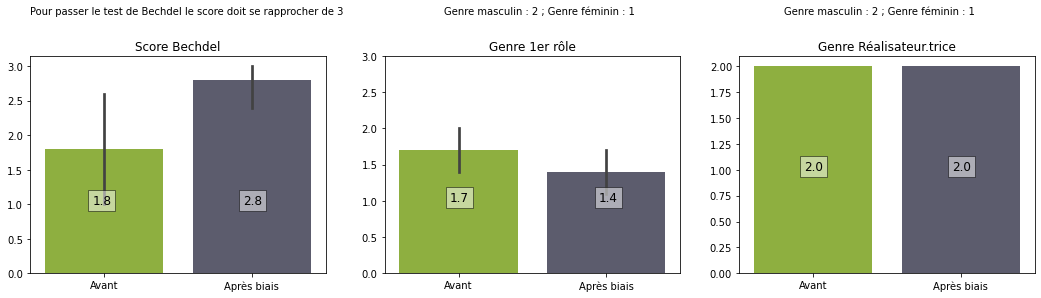

In [66]:
# Je plote l'effet de mon biais sur les différents paramètres
fig, ax = plt.subplots(1, 3, figsize=(18,4))

sns.barplot(data = metrics[['Moy_Bechdel', 
                          'Moy_Bechdel_biaisée']], 
            ax = ax[0],
            palette = ['#95C22D', '#595970'],
            linewidth = 1.5).set(title = 'Score Bechdel')
labels = ['Avant', 'Après biais']
_ = ax[0].set_xticklabels(labels)

box = sns.barplot(data = metrics[['Moy_Genre_1st_role', 
                          'Moy_Genre_1st_role_biaisée']], 
            ax = ax[1],
            palette = ['#95C22D', '#595970'],
            linewidth = 1.5).set(title = 'Genre 1er rôle')

ax[1].set_ylim([0, 3])
labels = ['Avant', 'Après biais']
_ = ax[1].set_xticklabels(labels)

_ = sns.barplot(data = metrics[['Moy_Genre_director',
                          'Moy_Genre_director_biaisée']], 
            ax = ax[2],
            palette = ['#95C22D', '#595970'],
            linewidth = 1.5).set(title = 'Genre Réalisateur.trice')
labels = ['Avant', 'Après biais']
_ = ax[2].set_xticklabels(labels)

# Je rajoute des commentaires pour aider le lecteur
_ = plt.text(-5.3,2.5, 'Pour passer le test de Bechdel le score doit se rapprocher de 3', fontsize = 10)
_ = plt.text(-2.5,2.5, 'Genre masculin : 2 ; Genre féminin : 1', fontsize = 10)
_ = plt.text(-0.2,2.5, 'Genre masculin : 2 ; Genre féminin : 1', fontsize = 10)

# J'affiche les medianes sur les plots
_ = ax[0].text(-0.08, 1, f"{np.round(np.nanmean(metrics['Moy_Bechdel']),2)}", 
           fontsize = 12, 
           bbox = dict(facecolor = 'white', alpha=0.5))
_ = ax[0].text(0.94, 1, f"{np.round(np.nanmean(metrics['Moy_Bechdel_biaisée']),2)}", 
           fontsize = 12, 
           bbox = dict(facecolor = 'white', alpha=0.5))

_ = ax[1].text(-0.06, 1, f"{np.round(np.nanmean(metrics['Moy_Genre_1st_role']),2)}", 
           fontsize = 12, 
           bbox = dict(facecolor = 'white', alpha=0.5))
_ = ax[1].text(0.95, 1, f"{np.round(np.nanmean(metrics['Moy_Genre_1st_role_biaisée']),2)}", 
           fontsize = 12, 
           bbox = dict(facecolor = 'white', alpha=0.5))

_ = ax[2].text(-0.06, 1, f"{np.round(np.nanmean(metrics['Moy_Genre_director']),2)}", 
           fontsize = 12, 
           bbox = dict(facecolor = 'white', alpha=0.5))
_ = ax[2].text(0.94, 1, f"{np.round(np.nanmean(metrics['Moy_Genre_director_biaisée']),2)}", 
           fontsize = 12, 
           bbox = dict(facecolor = 'white', alpha=0.5))

fig.tight_layout()  
fig.savefig('Fig_8.png')

Je regarde maintenant si mon biais fonctionne sur l'ensemble de mon dataset : 

In [43]:
biais_bechdel_final = []
biais_cast_genre_final = []
biais_genre_director_final = []

bechdel_final = []
cast_genre_final = []
genre_director_final = []

for i in data_cleaned['TMDb_id'] : 
    test = get_recommendations(i, cosine_sim2).index
    reco_test = data_cleaned.loc[test, ['Titre','Bechdel', 'Cast_genre_1', 'Genre_director', 'Poster']]
    
    bechdel_test = reco_test.replace('nan', np.nan).dropna().sort_values(by = 'Bechdel', ascending = False)
    if bechdel_test.shape[0] > 10 : 
        bechdel_test = bechdel_test.iloc[0:10]
    cast_genre_test = reco_test.replace('nan', np.nan).dropna().sort_values(by = 'Cast_genre_1', ascending = True)
    if cast_genre_test.shape[0] > 10 : 
        cast_genre_test = cast_genre_test.iloc[0:10]
    genre_director_test = reco_test.replace('nan', np.nan).dropna().sort_values(by = 'Genre_director', ascending = True)
    if genre_director_test.shape[0] > 10 : 
        genre_director_test = genre_director_test.iloc[0:10]
    
    final_reco_test = pd.concat([bechdel_test, cast_genre_test, genre_director_test], axis = 0)
    biais_bechdel_final.append(final_reco_test['Bechdel'].astype('float64').mean())
    biais_cast_genre_final.append(final_reco_test['Cast_genre_1'].astype('float64').mean())
    biais_genre_director_final.append(final_reco_test['Genre_director'].astype('float64').mean())
    
    final_reco_test.drop_duplicates(inplace = True)
    final_reco_test = final_reco_test.sort_values(by = 'Cast_genre_1', ascending = True)
    if final_reco_test.shape[0] > 10 : 
        final_reco_test[0:10]
    
    if reco_test.shape[0] > 10 : 
        reco_test = reco_test.iloc[0:10]
    bechdel_final.append(reco_test['Bechdel'].astype('float64').mean())
    cast_genre_final.append(reco_test['Cast_genre_1'].astype('float64').mean())
    genre_director_final.append(reco_test['Genre_director'].astype('float64').mean())


In [44]:
# Je récupère les moyennes de chaque paramètre
all_metrics = [bechdel_final,
               biais_bechdel_final,
               cast_genre_final,
               biais_cast_genre_final, 
               genre_director_final,
               biais_genre_director_final]

# Je mets toutes ces moyennes en forme de DataFrame
metrics = pd.DataFrame(all_metrics[0], columns = ['0'])

for i in range(1,6) :
    metrics = pd.concat([metrics, pd.DataFrame(all_metrics[i], columns = [str(i)])], axis = 1)

metrics.rename(columns={'0': 'Moy_Bechdel', 
                        '1': 'Moy_Bechdel_biaisée',
                        '2': 'Moy_Genre_1st_role',
                        '3': 'Moy_Genre_1st_role_biaisée',
                        '4' : 'Moy_Genre_director',
                        '5' : 'Moy_Genre_director_biaisée'}, inplace=True)
metrics

Moy_Bechdel  Moy_Bechdel_biaisée  Moy_Genre_1st_role  \
0         1.500000             1.400000                 1.9   
1         1.900000             2.333333                 1.9   
2         1.250000             2.900000                 1.9   
3         2.666667             2.766667                 1.6   
4         3.000000             2.600000                 1.5   
...            ...                  ...                 ...   
11706          NaN             1.000000                 1.8   
11707     1.333333             2.600000                 1.7   
11708     1.333333             2.666667                 1.7   
11709     2.571429             3.000000                 1.5   
11710          NaN                  NaN                 2.0   

       Moy_Genre_1st_role_biaisée  Moy_Genre_director  \
0                        1.800000                 1.9   
1                        1.866667                 2.0   
2                        1.433333                 2.0   
3                        1.700000                 1.9   
4                        1.300000                 1.7   
...                           ...                 ...   
11706                    1.666667                 2.0   
11707                    1.533333                 2.0   
11708                    1.466667                 2.0   
11709                    1.033333                 1.5   
11710                         NaN                 2.0   

       Moy_Genre_director_biaisée  
0                        1.900000  
1                        2.000000  
2                        1.600000  
3                        1.533333  
4                        1.700000  
...                           ...  
11706                    2.000000  
11707                    1.800000  
11708                    1.800000  
11709                    1.400000  
11710                         NaN  

[11711 rows x 6 columns]

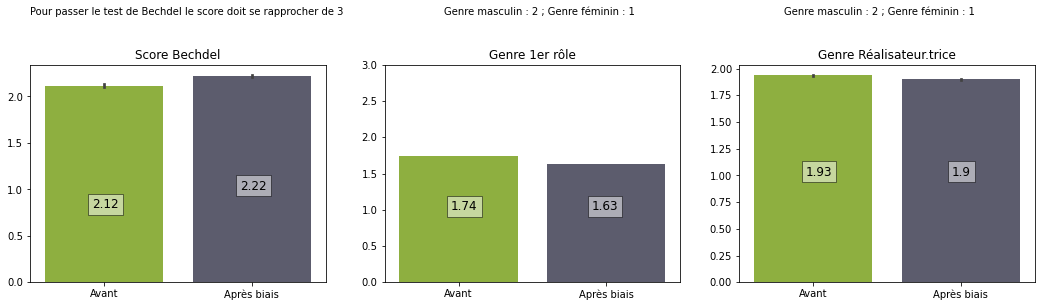

In [45]:
# Je plote l'effet de mon biais sur les différents paramètres
fig, ax = plt.subplots(1, 3, figsize=(18,4))

sns.barplot(data = metrics[['Moy_Bechdel', 
                          'Moy_Bechdel_biaisée']], 
            ax = ax[0],
            palette = ['#95C22D', '#595970'],
            linewidth = 1.5).set(title = 'Score Bechdel')
labels = ['Avant', 'Après biais']
_ = ax[0].set_xticklabels(labels)

box = sns.barplot(data = metrics[['Moy_Genre_1st_role', 
                          'Moy_Genre_1st_role_biaisée']], 
            ax = ax[1],
            palette = ['#95C22D', '#595970'],
            linewidth = 1.5).set(title = 'Genre 1er rôle')

ax[1].set_ylim([0, 3])
labels = ['Avant', 'Après biais']
_ = ax[1].set_xticklabels(labels)

_ = sns.barplot(data = metrics[['Moy_Genre_director',
                          'Moy_Genre_director_biaisée']], 
            ax = ax[2],
            palette = ['#95C22D', '#595970'],
            linewidth = 1.5).set(title = 'Genre Réalisateur.trice')
labels = ['Avant', 'Après biais']
_ = ax[2].set_xticklabels(labels)

# Je rajoute des commentaires pour aider le lecteur
_ = plt.text(-5.3,2.5, 'Pour passer le test de Bechdel le score doit se rapprocher de 3', fontsize = 10)
_ = plt.text(-2.5,2.5, 'Genre masculin : 2 ; Genre féminin : 1', fontsize = 10)
_ = plt.text(-0.2,2.5, 'Genre masculin : 2 ; Genre féminin : 1', fontsize = 10)

# J'affiche les medianes sur les plots
_ = ax[0].text(-0.08, 0.8, f"{np.round(np.nanmean(metrics['Moy_Bechdel']),2)}", 
           fontsize = 12, 
           bbox = dict(facecolor = 'white', alpha=0.5))
_ = ax[0].text(0.92, 1, f"{np.round(np.nanmean(metrics['Moy_Bechdel_biaisée']),2)}", 
           fontsize = 12, 
           bbox = dict(facecolor = 'white', alpha=0.5))

_ = ax[1].text(-0.05, 1, f"{np.round(np.nanmean(metrics['Moy_Genre_1st_role']),2)}", 
           fontsize = 12, 
           bbox = dict(facecolor = 'white', alpha=0.5))
_ = ax[1].text(0.9, 1, f"{np.round(np.nanmean(metrics['Moy_Genre_1st_role_biaisée']),2)}", 
           fontsize = 12, 
           bbox = dict(facecolor = 'white', alpha=0.5))

_ = ax[2].text(-0.05, 1, f"{np.round(np.nanmean(metrics['Moy_Genre_director']),2)}", 
           fontsize = 12, 
           bbox = dict(facecolor = 'white', alpha=0.5))
_ = ax[2].text(0.94, 1, f"{np.round(np.nanmean(metrics['Moy_Genre_director_biaisée']),2)}", 
           fontsize = 12, 
           bbox = dict(facecolor = 'white', alpha=0.5))

Sur l'ensemble du data set l'effet peut paraître décevant mais il faut noter l'écrasante représentation masculine :

# WordCloud

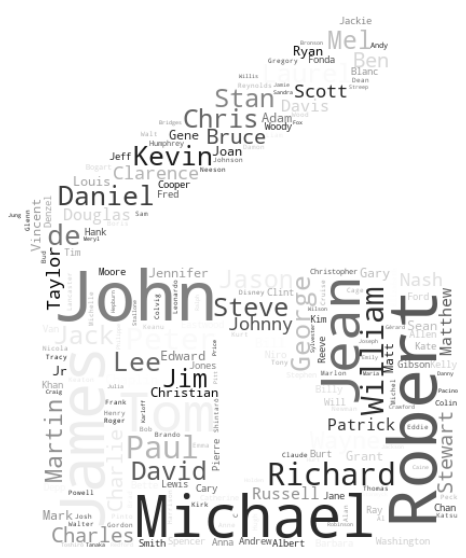

In [46]:
# Je crée un texte avec noms des premiers rôles
texte_cast = " ".join(title for title in data_cleaned['Cast_names_1'].dropna().astype(str))

mask = np.array(Image.open('/Users/justine.facchini/Sans titre - 1.png'))

# Je crée un nuage de mots provenant du texte créé
stopwords = set(STOPWORDS)
word_cloud = WordCloud(collocations = False, 
                        stopwords = stopwords, 
                        background_color = 'white',
                        colormap = 'gray',
                        mask = mask,
                        width = 2048, height = 1080).generate(texte_cast)

# J'affiche le nuage de mots
_ = plt.figure(figsize = (10,10))
_ = plt.imshow(word_cloud, interpolation = "bilinear")
_ = plt.axis("off")

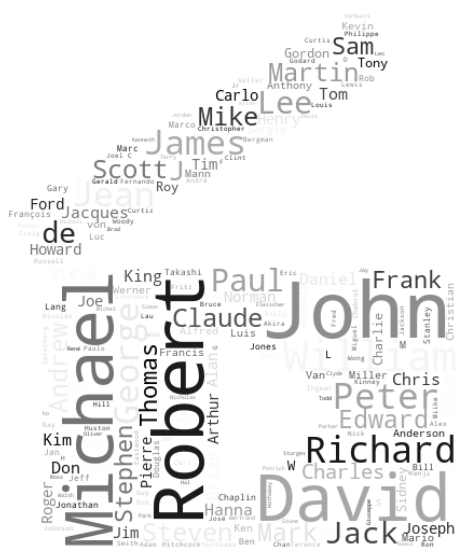

In [47]:
# Je crée un texte avec noms des réalisateurs.trices
texte_director = " ".join(title for title in data_transformed['Name_director'].dropna().astype(str))

mask = np.array(Image.open('/Users/justine.facchini/Sans titre - 1.png'))

# Je crée un nuage de mots provenant du texte créé
stopwords = set(STOPWORDS)
word_cloud = WordCloud(collocations = False, 
                        stopwords = stopwords, 
                        background_color = 'white',
                        colormap = 'gray',
                        mask = mask,
                        width = 2048, height = 1080).generate(texte_director)

# J'affiche le nuage de mots
_ = plt.figure(figsize = (10,10))
_ = plt.imshow(word_cloud, interpolation = "bilinear")
_ = plt.axis("off")